In [245]:
import torch
import torch.optim as optim
import torch.utils.data as data
from tqdm import tqdm
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset,DataLoader

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt


In [246]:
import torchvision.models as models
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [5]:
def index_classes(items):
    idx = {}
    for i in items:
        if (i not in idx):
            idx[i] = len(idx)
    return idx

class MiniImagenet(data.Dataset):
    """
    [[Source]](https://github.com/learnables/learn2learn/blob/master/learn2learn/vision/datasets/mini_imagenet.py)
    **Description**
    The *mini*-ImageNet dataset was originally introduced by Vinyals et al., 2016.
    It consists of 60'000 colour images of sizes 84x84 pixels.
    The dataset is divided in 3 splits of 64 training, 16 validation, and 20 testing classes each containing 600 examples.
    The classes are sampled from the ImageNet dataset, and we use the splits from Ravi & Larochelle, 2017.
    **References**
    1. Vinyals et al. 2016. “Matching Networks for One Shot Learning.” NeurIPS.
    2. Ravi and Larochelle. 2017. “Optimization as a Model for Few-Shot Learning.” ICLR.
    **Arguments**
    * **root** (str) - Path to download the data.
    * **mode** (str, *optional*, default='train') - Which split to use.
        Must be 'train', 'validation', or 'test'.
    * **transform** (Transform, *optional*, default=None) - Input pre-processing.
    * **target_transform** (Transform, *optional*, default=None) - Target pre-processing.
    * **download** (bool, *optional*, default=False) - Download the dataset if it's not available.
    **Example**
    ~~~python
    ~~~
    """
    def __init__(
        self,
        root,
        mode='train',
        transform=None,
        target_transform=None):
        super(MiniImagenet, self).__init__()
        self.root = os.path.expanduser(root)
        if not os.path.exists(self.root):
            os.mkdir(self.root)
        self.transform = transform
        self.target_transform = target_transform
        self.mode = mode
        pickle_file = os.path.join(self.root, 'mini-imagenet-cache-' + mode + '.pkl')

        with open(pickle_file, 'rb') as f:
            self.data = pickle.load(f)

   #     self.x = torch.from_numpy(self.data["image_data"]).permute(0, 3, 1, 2).float()
        self.x =self.data["image_data"]
        self.y = np.ones(len(self.x))

        # TODO Remove index_classes from here
        self.class_idx = index_classes(self.data['class_dict'].keys())
        for class_name, idxs in self.data['class_dict'].items():
            for idx in idxs:
                self.y[idx] = self.class_idx[class_name]

    def __getitem__(self, idx):
        data = self.x[idx]
        if self.transform:
            data = self.transform(data)
        return data, self.y[idx]

    def __len__(self):
        return len(self.x)


In [39]:
import math
import torch.nn as nn
from kernel import CannyFilter

In [310]:
transform=T.Compose([T.ToTensor(),T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
train_set=MiniImagenet(root="data/Mini",mode='train',transform=transform)
torch.manual_seed(0)
_, val_set = torch.utils.data.random_split(train_set, [30000, 8400])


## FIND BOTH CORRECT

In [ ]:
from tqdm import tqdm()

In [325]:
correct_dict=dict()

for ver in model_path:
    model = models.resnet18(num_classes=64)
    model.load_state_dict(torch.load(ver))
    model.to("cuda")
    model.eval()
    correct_dict[os.path.basename(ver).split(".")[0]]=[]
    with torch.no_grad():
        for idx,(img,label) in tqdm(enumerate(val_set)):
            img=img.unsqueeze(0).to("cuda")
            output=model(img)
            _, predicted = torch.max(output.data, 1)
            if (predicted==label)[0].item():
                correct_dict[os.path.basename(ver).split(".")[0]].append(idx)
import pickle
with open('saved_dictionary.pkl', 'wb') as f:
    pickle.dump(correct_dict, f)
    

8400it [00:29, 287.21it/s]
8400it [00:29, 281.55it/s]
8400it [00:26, 320.83it/s]


In [328]:
correct_dict.keys()

dict_keys(['edge_finetune_6', 'epoch_base_best', 'epoch_blur_best'])

In [400]:
setA=set(correct_dict['edge_finetune_6'])
setB=set(correct_dict['epoch_base_best'])
setC=set(correct_dict['epoch_blur_best'])

In [401]:
u = set.intersection(setA, setB, setC)

In [433]:
import random
random_idx=random.sample(list(u),16)

IMGS=torch.stack([val_set[x][0] for x in random_idx ])
LABELS=torch.tensor(np.stack([val_set[x][1] for x in random_idx])  )

In [434]:
import torchvision
grid_img = torchvision.utils.make_grid(IMGS, nrow=8,normalize=True)
data=pd.read_csv("MiniImageNet_cls.txt",sep=" ").iloc[:,0:2]
label_dict=data.set_index('key').to_dict()['values']
label_name=[label_dict[x] for x in  [k for k, v in train_set.class_idx.items()]]
gt=[label_name[x.long()] for x in LABELS]

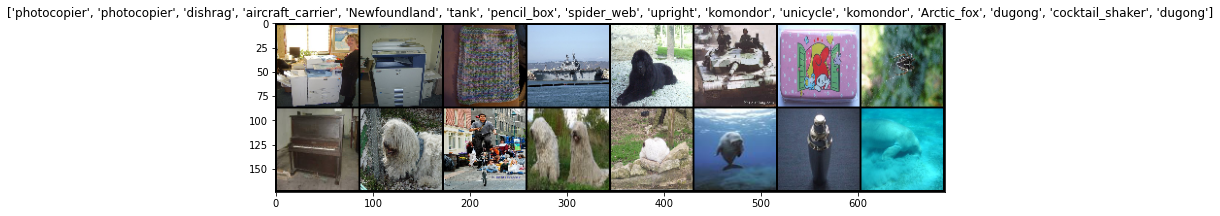

In [435]:
plt.figure(figsize=(12,8))
plt.title(gt)
plt.imshow(grid_img.permute(1, 2, 0))

# Grad CAM on GT

In [436]:
target_category =LABELS.long()

In [437]:
import pandas as pd
model_path=[os.path.join("models",x) for x in os.listdir("models")]

In [438]:
model_path

['models\\edge_finetune_6.h',
 'models\\epoch_base_best.h',
 'models\\epoch_blur_best.h']

## BASE BEST

EVAL MODE


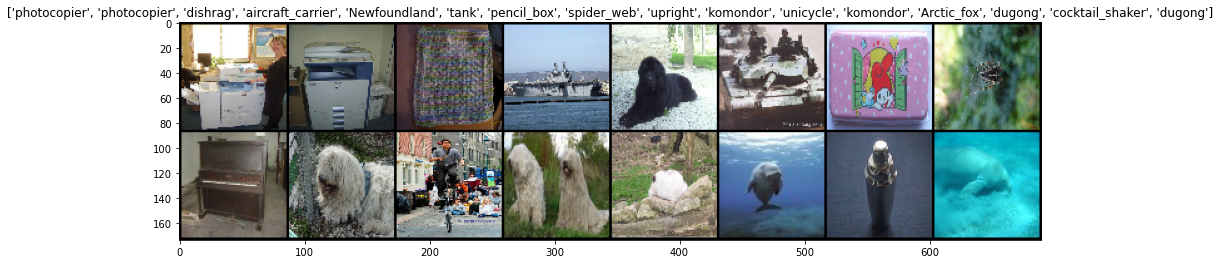

In [439]:
model = models.resnet18(num_classes=64)
model.load_state_dict(torch.load(model_path[1]))
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

model.eval()
print("EVAL MODE")

grayscale_cam = cam(input_tensor=IMGS, target_category=target_category)
output=model(IMGS.to("cuda"))
_, predicted = torch.max(output.data, 1)
img_numpy=np.stack([np.array(T.ToPILImage()(x*0.5+0.5)) for x in IMGS])
imgs=np.concatenate([show_cam_on_image(img_numpy[x]/255, grayscale_cam[x], use_rgb=True) for x in range(16)],axis=1)
fig,ax=plt.subplots(figsize=(16,4))
ax.title.set_text(gt)
ax.imshow(grid_img.permute(1, 2, 0))

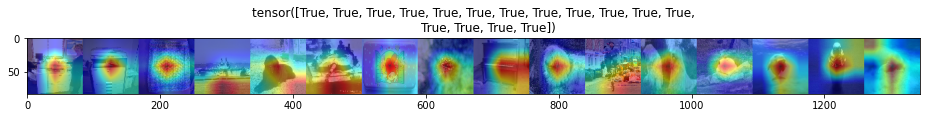

In [440]:
fig,ax=plt.subplots(figsize=(16,4))
ax.title.set_text((predicted.detach().cpu() == LABELS))
ax.imshow(imgs)

## BLUR

EVAL MODE


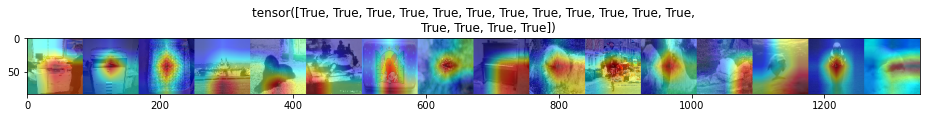

In [441]:
import torchvision.models as models
model = models.resnet18(num_classes=64)
model.load_state_dict(torch.load(model_path[2]))
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
model.eval()
print("EVAL MODE")

grayscale_cam = cam(input_tensor=IMGS, target_category=target_category)
output=model(IMGS.to("cuda"))
_, predicted = torch.max(output.data, 1)
img_numpy=np.stack([np.array(T.ToPILImage()(x*0.5+0.5)) for x in IMGS])
imgs=np.concatenate([show_cam_on_image(img_numpy[x]/255, grayscale_cam[x], use_rgb=True) for x in range(16)],axis=1)

fig,ax=plt.subplots(figsize=(16,4))
ax.title.set_text((predicted.detach().cpu() == LABELS))
ax.imshow(imgs)

## Edge

EVAL MODE


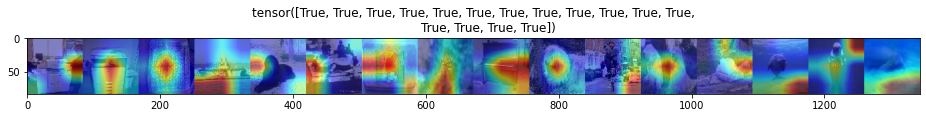

In [442]:
import torchvision.models as models
model = models.resnet18(num_classes=64)
model.load_state_dict(torch.load(model_path[0]))
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
model.eval()
print("EVAL MODE")

grayscale_cam = cam(input_tensor=IMGS, target_category=target_category)
output=model(IMGS.to("cuda"))
_, predicted = torch.max(output.data, 1)
img_numpy=np.stack([np.array(T.ToPILImage()(x*0.5+0.5)) for x in IMGS])
imgs=np.concatenate([show_cam_on_image(img_numpy[x]/255, grayscale_cam[x], use_rgb=True) for x in range(16)],axis=1)

fig,ax=plt.subplots(figsize=(16,4))
ax.title.set_text((predicted.detach().cpu() == LABELS))
ax.imshow(imgs)